## setup

In [1]:
import numpy as np
import time
import pandas as pd
import os
import random


import PIL.Image as Image
import matplotlib.pylab as plt
from tqdm import tqdm
from textwrap import wrap

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras


from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend as K
from keras.utils import np_utils
from tensorflow.keras.optimizers import Adam, RMSprop

import datetime

%load_ext tensorboard

c:\Users\angga\anaconda3\envs\env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### use gpu

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
  tf.config.experimental.set_memory_growth(device, True)

print('Num Gpu Avaible' ,len(physical_devices))

Num Gpu Avaible 1


In [3]:
tf.test.is_built_with_cuda

<function tensorflow.python.platform.test.is_built_with_cuda()>

In [4]:
import sys
sys.version

'3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]'

### Read name file classes.txt

In [5]:
f = open('classes.txt')
label = []
name = []
for line in f.readlines():
    label.append(int(line.split()[0]))
    name.append(' '.join(line.split()[1:]))
classes = pd.DataFrame([label, name]).T
classes.columns = ['label','name']
classes

label                        name
0       1            rice leaf roller
1       2       rice leaf caterpillar
2       3           paddy stem maggot
3       4          asiatic rice borer
4       5           yellow rice borer
..    ...                         ...
97     98        Chlumetia transversa
98     99  Mango flat beak leafhopper
99    100  Rhytidodera bowrinii white
100   101       Sternochetus frigidus
101   102                Cicadellidae

[102 rows x 2 columns]

In [6]:
train_df = pd.read_csv('train.txt',sep=' ',header=None, engine='python')
train_df.columns = ['image_path','label']

test_df = pd.read_csv('test.txt',sep=' ',header=None, engine='python')
test_df.columns = ['image_path','label']

val_df = pd.read_csv('val.txt',sep=' ',header=None, engine='python')
val_df.columns = ['image_path','label']

train_df.head()

image_path  label
0  00002.jpg      0
1  00003.jpg      0
2  00005.jpg      0
3  00006.jpg      0
4  00008.jpg      0

## Data preprocessing

## load dataset from directory

In [7]:
train_dir = 'classification/train'
test_dir = 'classification/test'
validation_dir = 'classification/val'


BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset  = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                       shuffle=True,
                                                            image_size=IMG_SIZE,
                                                            batch_size=BATCH_SIZE
                                                            )

validation_dataset   = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                image_size=IMG_SIZE,
                                                               batch_size=BATCH_SIZE)


test_dataset  = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=False,
                                                                image_size=IMG_SIZE,
                                                               batch_size=BATCH_SIZE)                                                               

Found 45095 files belonging to 102 classes.
Found 7508 files belonging to 102 classes.
Found 22619 files belonging to 102 classes.


### read name insect pest 

In [8]:
class_names = np.array(classes.name)
print(class_names)

['rice leaf roller' 'rice leaf caterpillar' 'paddy stem maggot'
 'asiatic rice borer' 'yellow rice borer' 'rice gall midge' 'Rice Stemfly'
 'brown plant hopper' 'white backed plant hopper'
 'small brown plant hopper' 'rice water weevil' 'rice leafhopper'
 'grain spreader thrips' 'rice shell pest' 'grub' 'mole cricket'
 'wireworm' 'white margined moth' 'black cutworm' 'large cutworm'
 'yellow cutworm' 'red spider' 'corn borer' 'army worm' 'aphids'
 'Potosiabre vitarsis' 'peach borer' 'english grain aphid' 'green bug'
 'bird cherry-oataphid' 'wheat blossom midge' 'penthaleus major'
 'longlegged spider mite' 'wheat phloeothrips' 'wheat sawfly'
 'cerodonta denticornis' 'beet fly' 'flea beetle' 'cabbage army worm'
 'beet army worm' 'Beet spot flies' 'meadow moth' 'beet weevil'
 'sericaorient alismots chulsky' 'alfalfa weevil' 'flax budworm'
 'alfalfa plant bug' 'tarnished plant bug' 'Locustoidea' 'lytta polita'
 'legume blister beetle' 'blister beetle' 'therioaphis maculata Buckton'
 'odont

###  Show the 102  images and labels from the training set:



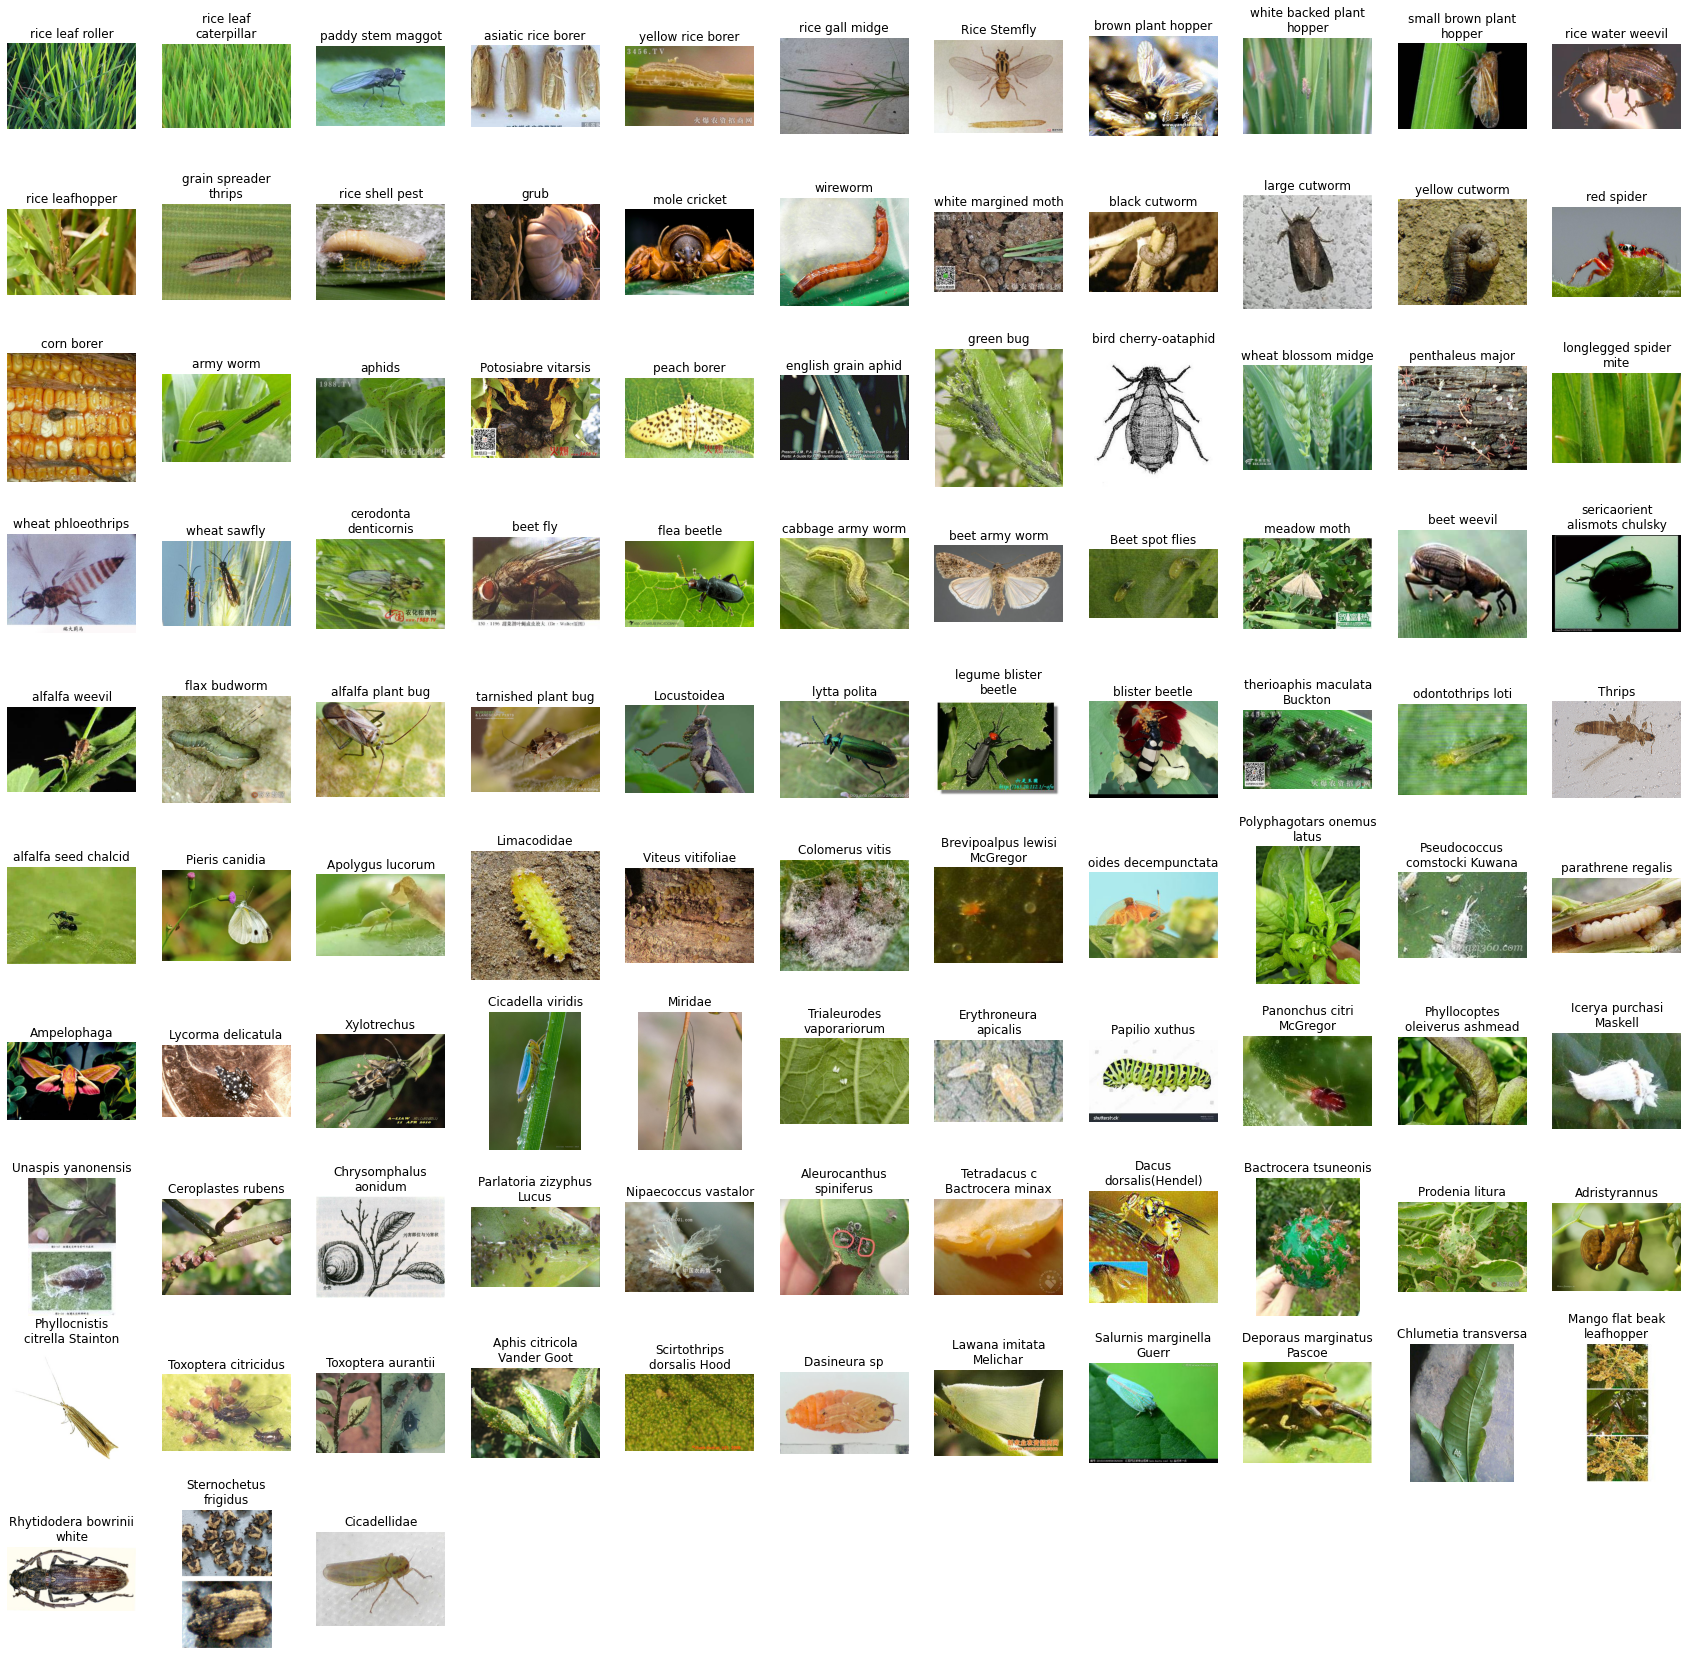

In [9]:
fig, axs = plt.subplots(10,11,figsize=(30,30))
images = []
for i in classes.label:
    random_img = random.choice(train_df[train_df.label==i-1].image_path.values)
    label = classes.name[i-1]
    img = plt.imread(os.path.join(train_dir,str(i-1),random_img))
    images.append(img)

[ax.imshow(image) for image,ax in zip(images,axs.ravel())]
[ax.set_title("\n".join(wrap(label,20))) for label,ax in zip(list(classes.name),axs.ravel())]
[ax.set_axis_off() for ax in axs.ravel()]
plt.show()

In [10]:
# val_batches = tf.data.experimental.cardinality(validation_dataset)
# test_dataset = validation_dataset.take(val_batches // 5)
# validation_dataset = validation_dataset.skip(val_batches // 5)

In [11]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 235
Number of test batches: 707


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the data performance guide.



In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.

In [13]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Let's repeatedly apply these layers to the same image and see the result.



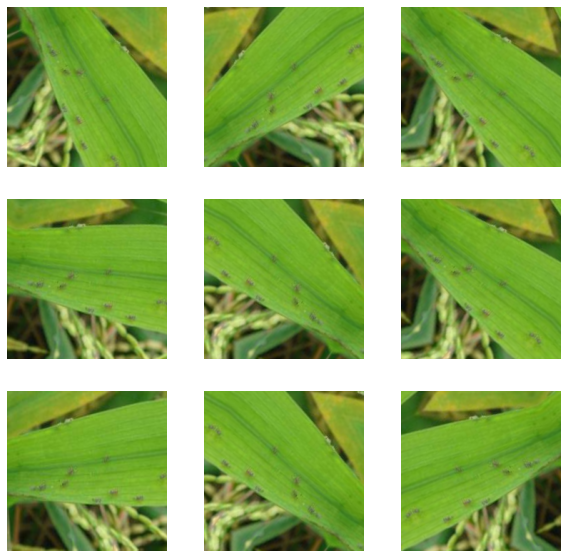

In [14]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV3` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [15]:
preprocess_input = tf.keras.layers.InputLayer(input_shape=IMG_SIZE + (3,))

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]
` using `tf.keras.layers.Rescaling`.

In [16]:
rescale = tf.keras.layers.Rescaling(1./255)

### Create the base model from the pre-trained convnets

In [106]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [107]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1, 1, 1280)



## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

In [108]:
base_model.trainable = False

In [109]:
base_model.summary()


Model: "MobilenetV3large"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_11 (Rescaling)        (None, 224, 224, 3)  0           input_19[0][0]                   
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_11[0][0]               
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
___________________________________________________________________________________

### Add a classification head

In [110]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() 
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image.

In [126]:
num_classes = len(class_names)# 7


prediction_layer = tf.keras.layers.Dense(num_classes,activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 102)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [132]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
# x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x =  tf.keras.layers.Dropout(rate=0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
MobilenetV3large (Functional (None, 1, 1, 1280)        4226432   
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1280)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              multiple                  130662    
Total params: 4,357,094
Trainable params: 130,662
Non-trainable params: 4,226,432
___________________________________________

In [133]:

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

### Train the model


In [134]:
NUM_EPOCHS = 10

history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=NUM_EPOCHS)

Epoch 1/10
1410/1410 [==============================] - 89s 59ms/step - loss: 1.8712 - accuracy: 0.5271 - val_loss: 1.7251 - val_accuracy: 0.5570
Epoch 2/10
1410/1410 [==============================] - 91s 65ms/step - loss: 1.6555 - accuracy: 0.5672 - val_loss: 1.6764 - val_accuracy: 0.5681
Epoch 3/10
1410/1410 [==============================] - 83s 59ms/step - loss: 1.5588 - accuracy: 0.5842 - val_loss: 1.6550 - val_accuracy: 0.5759
Epoch 4/10
1410/1410 [==============================] - 88s 62ms/step - loss: 1.5068 - accuracy: 0.5959 - val_loss: 1.6580 - val_accuracy: 0.5777
Epoch 5/10
1410/1410 [==============================] - 89s 63ms/step - loss: 1.4523 - accuracy: 0.6058 - val_loss: 1.6590 - val_accuracy: 0.5786
Epoch 6/10
1410/1410 [==============================] - 88s 63ms/step - loss: 1.4409 - accuracy: 0.6063 - val_loss: 1.6442 - val_accuracy: 0.5868
Epoch 7/10
1410/1410 [==============================] - 99s 70ms/step - loss: 1.4170 - accuracy: 0.6124 - val_loss: 1.6678 -

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

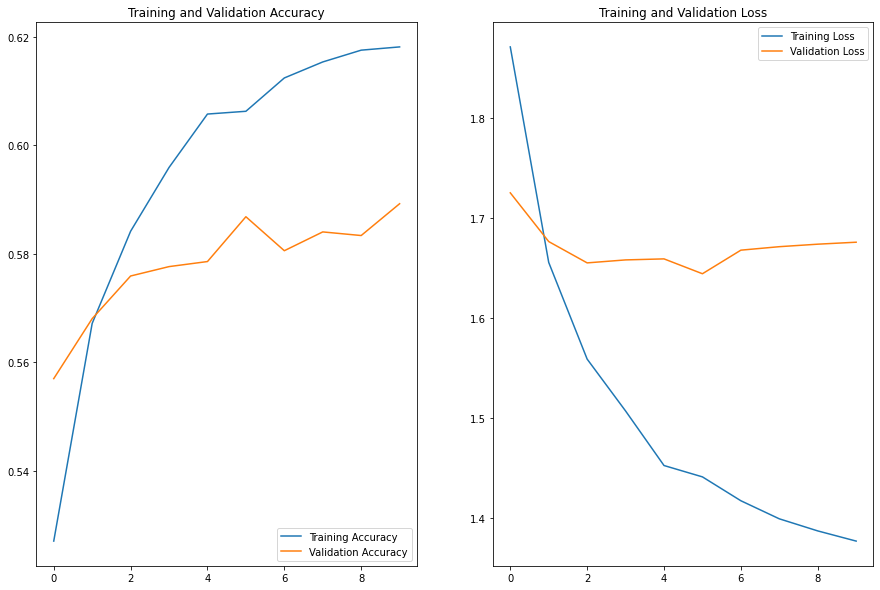

In [135]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(NUM_EPOCHS)

plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## FINE TUNING

### Un-freeze the top layers of the model


In [136]:
base_model.trainable = True

In [137]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  269


### Compile the model


In [138]:
base_learning_rate = 0.0001
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [139]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
MobilenetV3large (Functional (None, 1, 1, 1280)        4226432   
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1280)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              multiple                  130662    
Total params: 4,357,094
Trainable params: 4,308,758
Non-trainable params: 48,336
____________________________________________

In [140]:
len(model.trainable_variables)

133

### Continue training the model

In [141]:
fine_tune_epochs = 10
total_epochs =  NUM_EPOCHS  + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20


c:\Users\angga\anaconda3\envs\env\lib\site-packages\keras\backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


 248/1410 [====>.........................] - ETA: 2:12 - loss: 1.3027 - accuracy: 0.6471

KeyboardInterrupt: 

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

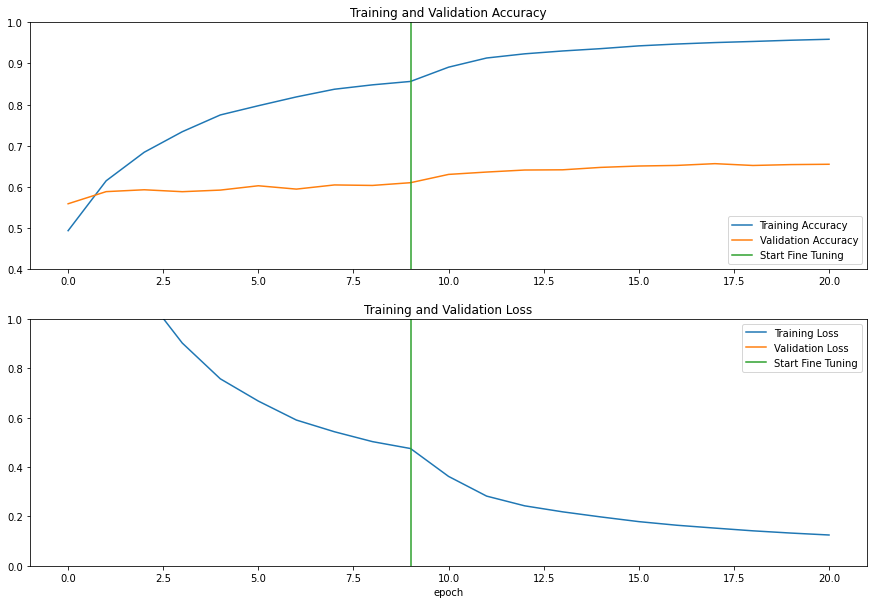

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1])
plt.plot([NUM_EPOCHS-1,NUM_EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([NUM_EPOCHS-1,NUM_EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)

707/707 - 35s - loss: 2.4631 - accuracy: 0.6545


In [ ]:
loss, accuracy = model.evaluate(train_dataset)
print('Test accuracy :', accuracy)

1410/1410 [==============================] - 70s 49ms/step - loss: 0.5285 - accuracy: 0.8357
Test accuracy : 0.8356802463531494


In [142]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

['grain spreader thrips' 'yellow rice borer' 'Pieris canidia'
 'cerodonta denticornis' 'Xylotrechus' 'Adristyrannus' 'odontothrips loti'
 'large cutworm' 'Miridae' 'wheat blossom midge' 'large cutworm'
 'Unaspis yanonensis' 'Potosiabre vitarsis' 'rice leaf caterpillar'
 'Pieris canidia' 'Panonchus citri McGregor' 'Icerya purchasi Maskell'
 'grub' 'cerodonta denticornis' 'asiatic rice borer' 'aphids' 'corn borer'
 'Ampelophaga' 'Dacus dorsalis(Hendel)' 'Nipaecoccus vastalor'
 'Ampelophaga' 'large cutworm' 'beet army worm'
 'Phyllocnistis citrella Stainton' 'black cutworm' 'Lycorma delicatula'
 'green bug']


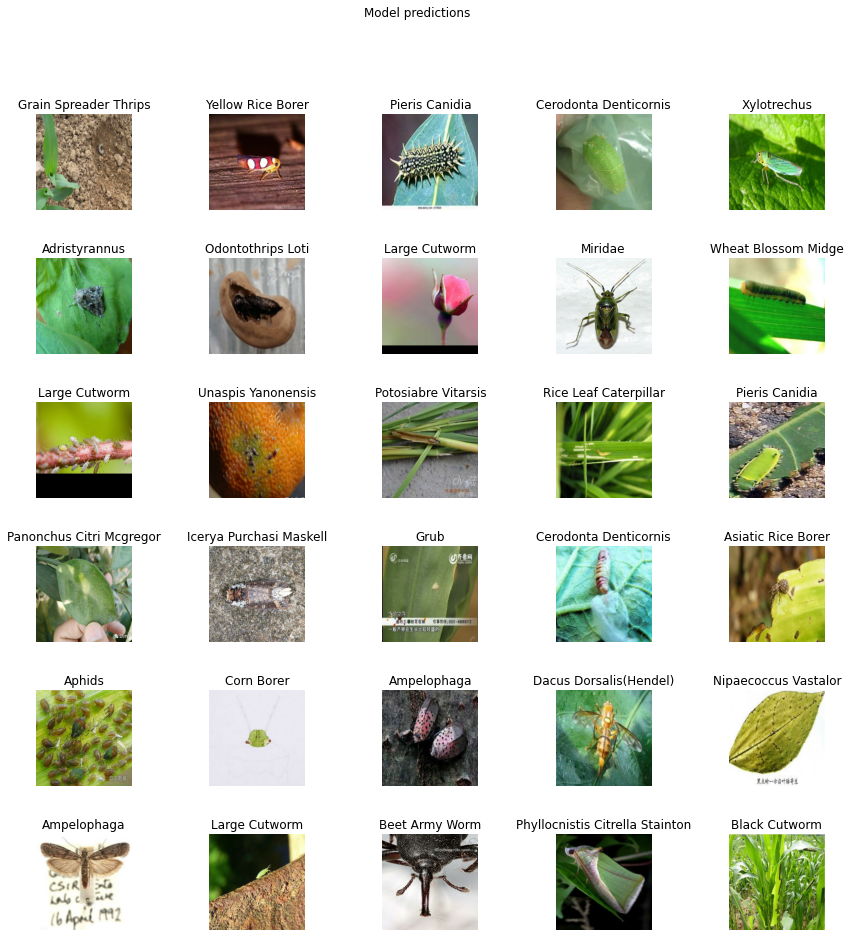

In [143]:
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n].numpy().astype('uint8'))
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

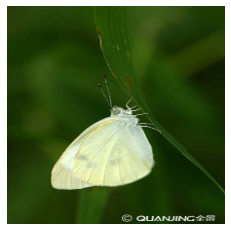

This image most likely belongs to Thrips with a 99.51 percent confidence.


In [152]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]

plt.imshow(image.numpy().astype('uint8'))
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(prediction_scores)], 100 * np.max(prediction_scores))
)

### saved model

In [371]:
model_name = "mobilenetv3" 

saved_model_path = f"/tmp/saved_flowers_model_{model_name}"
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: /tmp/saved_flowers_model_mobilenetv3\assets


INFO:tensorflow:Assets written to: /tmp/saved_flowers_model_mobilenetv3\assets


## Deployment to TensorFlow Lite

In [372]:
import itertools


optimize_lite_model = True 
num_calibration_examples = 60 
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_ds for image in batch),
      num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

with open(f"/tmp/lite_flowers_model_{model_name}.tflite", "wb") as f:
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

Wrote TFLite model of 23907956 bytes.


In [373]:
interpreter = tf.lite.Interpreter(model_content=lite_model_content)
# This little helper wraps the TFLite Interpreter as a numpy-to-numpy function.
def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [374]:
num_eval_examples = 50 
eval_dataset = ((image, label)  # TFLite expects batch size 1.
                for batch in train_ds
                for (image, label) in zip(*batch))
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in eval_dataset:
  probs_lite = lite_model(image[None, ...])[0]
  probs_tf = model(image[None, ...]).numpy()[0]
  y_lite = np.argmax(probs_lite)
  y_tf = np.argmax(probs_tf)
  y_true = np.argmax(label)
  count +=1
  if y_lite == y_tf: count_lite_tf_agree += 1
  if y_lite == y_true: count_lite_correct += 1
  if count >= num_eval_examples: break
print("TFLite model agrees with original model on %d of %d examples (%g%%)." %
      (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
print("TFLite model is accurate on %d of %d examples (%g%%)." %
      (count_lite_correct, count, 100.0 * count_lite_correct / count))

TFLite model agrees with original model on 46 of 50 examples (92%).
TFLite model is accurate on 2 of 50 examples (4%).


In [147]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [148]:
interpreter.get_signature_list()

{}

In [ ]:
classify_lite = interpreter.get_signature_list('serving_default')
classify_lite

In [ ]:
model = Model()

# Save the model
SAVED_MODEL_PATH = 'content/saved_models/coding'

tf.saved_model.save(
    model, SAVED_MODEL_PATH,
    signatures={
      'encode': model.encode.get_concrete_function(),
      'decode': model.decode.get_concrete_function()
    })

# Convert the saved model using TFLiteConverter
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_PATH)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
]
tflite_model = converter.convert()

# Print the signatures from the converted model
interpreter = tf.lite.Interpreter(model_content=tflite_model)
signatures = interpreter.get_signature_list()
print(signatures)

In [ ]:
y_test = np.concatenate([y for x, y in test_dataset], axis=0)
prediction = model.predict(test_dataset)
pred = np.argmax(prediction,axis=1)
print(pred)    
from sklearn.metrics import accuracy_score

accuracy_score(pred,y_test)

In [ ]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(pred, y_test)
confusion_matrix = confusion_matrix.astype(int)

In [ ]:
import plotly.figure_factory as ff
def plot_confusion_matrix(z,x,y):
    x = x
    y = x[::-1].copy()
    z = z[::-1]
    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z[::-1]]

    # set up figure 
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='<i><b>Matriz de Confusão</b></i>',
                      #xaxis = dict(title='x'),
                      #yaxis = dict(title='x')
                     )

    # add custom xaxis title
    fig.add_annotation(dict(font=dict(color="black",size=14),
                            x=0.5,
                            y=-0.15,
                            showarrow=False,
                            text="Valor Previsto",
                            xref="paper",
                            yref="paper"))

    # add custom yaxis title
    fig.add_annotation(dict(font=dict(color="black",size=14),
                            x=-0.35,
                            y=0.5,
                            showarrow=False,
                            text="Valor Real",
                            textangle=-90,
                            xref="paper",
                            yref="paper"))



    # adjust margins to make room for yaxis title
    fig.update_layout(margin=dict(t=50, l=200))
    fig.update_yaxes(type='category')
    # add colorbar
    fig['data'][0]['showscale'] = True
    fig.show()

In [ ]:
import plotly.express as px

z = confusion_matrix
fig = px.imshow(z)
fig.show()